In [ ]:
import jax.numpy as np
import jax
from jax import grad, jacfwd, hessian, jacrev
from jax import vmap
from jax import jit
from jax import random
from jax.lax import cond 
import numpy
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def sigmoid(x):
    #return x/(1. + np.exp(-x))
    #return np.tanh(x)
    return 1./(1. + np.exp(-x))

In [ ]:
def nn_V(params, t, c):
    M0 = c['M0']
    M1 = c['M1']
    M2 = c['M2']
    #t = (t/c['t1'] -0.5)*2.
    t = (t - c['t0'])/(c['t1']- c['t0']) -0.5
    w0 = params[:M0]#np.reshape(params[:M0], (1, M0))
    b0 = params[M0:2*M0]
    w1 = np.reshape(params[2*M0: 2*M0 + M0*M1], (M0, M1))
    b1 = params[2*M0 + M0*M1: 2*M0 + M0*M1 + M1]
    w2 = np.reshape(params[2*M0 + M0*M1 + M1: 2*M0 + M0*M1 + M1 + M1*M2], (M1, M2))
    b2 = params[2*M0 + M0*M1 + M1 + M1*M2 : 2*M0 + M0*M1 + M1 + M1*M2+M2]
    w3 = np.reshape(params[2*M0 + M0*M1 + M1 + M1*M2+M2:2*M0 + M0*M1 + M1 + M1*M2+M2+11*M2], (M2, 11))
    b3 = params[2*M0 + M0*M1 + M1 + M1*M2+M2+11*M2 : 2*M0 + M0*M1 + M1 + M1*M2+M2+11*M2+11]

    t0 = sigmoid(np.tensordot(t, w0, 0, precision=jax.lax.Precision.HIGHEST) + b0)
    #t0 = sigmoid(np.dot(t, w0) + b0)
    t1 = sigmoid(np.dot(t0, w1) + b1)
    t2 = sigmoid(np.dot(t1, w2) + b2) #+ t0
    t3 = np.dot(t2, w3) + b3 
    res = np.array([c['ics'][0] + (t+0.5)*t3[0],
                    c['ics'][1] + (t+0.5)*t3[1],
                    c['ics'][2] + (t+0.5)*t3[2], 
                    (0.5-t)*t3[3],
                    (0.5-t)*t3[4],
                   (0.5-t)*t3[5],
                   (0.5-t)*t3[6],
                   (0.5-t)*t3[7],
                   (0.5-t)*t3[8],
                    0.9*sigmoid(t3[9]),
                    0.9*sigmoid(t3[10])]) #phi1,phi2, rho, L11,L21, L13, L21, L22, L23, u1, u2
    return res

v_nn_V = jax.vmap(nn_V, (None, 0, None))
dNNdt_V = jacrev(nn_V, 1)#jacrev(nn, 1)
v_dNNdt_V = jax.vmap(dNNdt_V, (None, 0, None), 0)

In [ ]:
def F(nn_in, c):
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]
    return np.array([(1. - c['n'][0])*(c['z'][0]*phi1 - phi1*u1*u1 - rho/c['rhoMax'] * phi1*(1.-u1)*c['v'][0]),
                     (1. - c['n'][1])*(c['z'][1]*phi2 - phi2*u2*u2 - rho/c['rhoMax'] * phi2*(1.-u2)*c['v'][1])])



In [ ]:
def f(nn_in, c):
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]
    return np.array([-c['b'][0]*phi1 + c['n'][0]*(c['z'][0]*phi1 - phi1*u1*u1 - rho/c['rhoMax'] * phi1*(1.-u1)*c['v'][0]),
                     -c['b'][1]*phi2 + c['n'][1]*(c['z'][1]*phi2 - phi2*u2*u2 - rho/c['rhoMax'] * phi2*(1.-u2)*c['v'][1])])

In [ ]:
def g(nn_in, c):
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]
    return -c['k']*rho + phi1*(1. - u1) + phi2*(1. - u2)

In [ ]:
def H(nn_in, c):
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]
    F0 = F(nn_in, c)
    f0 = f(nn_in, c)
    g0 = g(nn_in, c)
    return np.array([F0[0] + L11*f0[0] + L12*f0[1] + L13*g0,
                     F0[1] + L21*f0[0] + L22*f0[1] + L23*g0])


In [ ]:
def L(nn_in, c):
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]
    return np.array([
        -( (1. - c['n'][0])*(c['z'][0] - u1*u1 - rho/c['rhoMax'] * (1.-u1)*c['v'][0]) + 
          L11*(-c['b'][0] + c['n'][0]*(c['z'][0] - u1*u1 - rho/c['rhoMax'] * (1.-u1)*c['v'][0]) ) +
          L13*(1.-u1)),
        -(L12*(-c['b'][1] + c['n'][1]*(c['z'][1] - u2*u2 - rho/c['rhoMax'] * (1.-u2)*c['v'][1])) +
          L13*(1.-u2)), 
        -((1. - c['n'][0])*(- 1.0/c['rhoMax'] * phi1*(1.-u1)*c['v'][0])+
          L11*(c['n'][0]*(- 1.0/c['rhoMax'] * phi1*(1.-u1)*c['v'][0]))+
          L12*(c['n'][1]*(- 1.0/c['rhoMax'] * phi2*(1.-u2)*c['v'][1]))+
          L13*(-c['k'])),

        -(L21*(-c['b'][0] + c['n'][0]*(c['z'][0] - u1*u1 - rho/c['rhoMax'] * (1.-u1)*c['v'][0]) ) +
          L23*(1.-u1)),
        -( (1. - c['n'][1])*(c['z'][1] - u2*u2 - rho/c['rhoMax'] * (1.-u2)*c['v'][1]) + 
          L22*(-c['b'][1] + c['n'][1]*(c['z'][1] - u2*u2 - rho/c['rhoMax'] * (1.-u1)*c['v'][1]) ) +
          L23*(1.-u2)), 
        -((1. - c['n'][1])*(- 1.0/c['rhoMax'] * phi2*(1.-u2)*c['v'][1])+
          L21*(c['n'][0]*(- 1.0/c['rhoMax'] * phi1*(1.-u1)*c['v'][0]))+
          L22*(c['n'][1]*(- 1.0/c['rhoMax'] * phi2*(1.-u2)*c['v'][1]))+
          L23*(-c['k'])),
                 
    ])

In [ ]:
def opt_u(nn_in, c):
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]
    return np.array([np.clip(
        0.5*(-L13*c['rhoMax'] + rho*c['v'][0] - c['n'][0]*rho*c['v'][0] + c['n'][0]*L11*rho*c['v'][0])/(c['rhoMax']*(1. - c['n'][0]+ c['n'][0]*L11)),
        0., 0.9),
        np.clip(
        0.5*(-L23*c['rhoMax'] + rho*c['v'][1] - c['n'][1]*rho*c['v'][1] + c['n'][1]*L22*rho*c['v'][1])/(c['rhoMax']*(1. - c['n'][1]+ c['n'][1]*L22)),
        0., 0.9)])
    

In [ ]:
def answ(nn_in, c):
    us = opt_u(nn_in, c)
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]

    H10 = H(np.stack([phi1,phi2, rho, L11,L21, L13, L21, L22, L23, np.zeros(phi1.shape), u2],axis=1), c)[0]
    H11 = H(np.stack([phi1,phi2, rho, L11,L21, L13, L21, L22, L23, np.zeros(phi1.shape) + 0.9, u2],axis=1), c)[0]
    H1s = H(np.stack([phi1,phi2, rho, L11,L21, L13, L21, L22, L23, us[0, :], u2],axis=1), c)[0]
    u1 = np.where(H10 > H11, 0.0, 0.9)
    H_ = np.where(H10 > H11, H10, H11)
    u1 = np.where(H1s >= H_, us[0, :], u1)

    H20 = H(np.stack([phi1,phi2, rho, L11,L21, L13, L21, L22, L23, u1, np.zeros(phi1.shape)],axis=1), c)[0]
    H21 = H(np.stack([phi1,phi2, rho, L11,L21, L13, L21, L22, L23, u1, np.zeros(phi1.shape)+0.9],axis=1), c)[0]
    H2s = H(np.stack([phi1,phi2, rho, L11,L21, L13, L21, L22, L23, us[1, :], u2],axis=1), c)[0]
    u2 = np.where(H20 > H21, 0.0, 0.9)
    H_ = np.where(H20 > H21, H20, H21)
    u2 = np.where(H2s >= H_, us[1, :], u2)
    return np.array([u1, u2])

In [ ]:
def loss(params, t, c):
    nn_in = v_nn_V(params, t, c)
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]

    dnn_in = v_dNNdt_V(params, t, c)
    dphi1 = dnn_in[:, 0]
    dphi2 = dnn_in[:, 1] 
    drho = dnn_in[:, 2] 
    dL11 = dnn_in[:, 3]
    dL12 = dnn_in[:, 4] 
    dL13 = dnn_in[:, 5] 
    dL21 = dnn_in[:, 6] 
    dL22 = dnn_in[:, 7] 
    dL23 = dnn_in[:, 8] 
    du1 = dnn_in[:, 9] 
    du2 = dnn_in[:, 10]
    f0 = f(nn_in, c)
    g0 = g(nn_in, c)
    L0 = L(nn_in, c)
    ans = answ(nn_in, c)
    res = 0.
    res += (dphi1 - f0[0])**2 + (dphi2 - f0[1])**2
    res += (drho - g0)**2
    res += (dL11 - L0[0])**2 + (dL12 - L0[1])**2 + (dL13 - L0[2])**2
    res += (dL21 - L0[3])**2 + (dL22 - L0[4])**2 + (dL23 - L0[5])**2
    res += (ans[0] - u1)**2 + (ans[1] - u2)**2
    return res.mean()

dLoss = grad(loss, 0)


In [ ]:
#consts = {'N':3., 'M0':4, 'M1': 16, 'M2': 64, 'ics': [1., 0.], 't0':0., 't1':1., 'rhoMax': 1., 'b': 0.5, 'n': 0.5, 'k':0.5, 'z': 0.1, 'v':1.0}
consts = {'N':1, 'M0':4, 'M1': 32, 'M2': 128, 'ics': [1., 1.5, 0.], 't0':0., 't1':1., 'rhoMax': 1., 'b': [0.5,0.5], 'n': [0.5,0.5], 'k':0.5, 'z': [1.,1.], 'v':[1.0,1.0]}

In [ ]:
inputs = np.linspace(consts['t0'], consts['t1'], num=5000)

In [ ]:
epochs = 2500

learning_rate = 0.01
#inputs = np.linspace(np.array([0., 1e-4]), np.array([consts['t1']-1e-4, consts['ics'][0]]), num=501)
batch_size = 500
key = random.PRNGKey(0)
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
params = (random.normal(key, shape=(2*M0 + M0*M1 + M1 + M1*M2+M2+11*M2+11, )))*0.1
#params = params - params.min()
#params /= params.max()
v = 0.0
m = 0.0
b1 = 0.9
b2 = 0.999
bestLoss = 1000000.0
bestParams = params
ec = 1

In [ ]:
bad_ep = 0
step = -1e-4
k = 0
PastParams = params
max_lr=0.2
for epoch in range(epochs):
    i = numpy.random.randint(0, inputs.shape[0], size=batch_size)
    #sample = inputs[i]
    sample = inputs
    #rnd = (numpy.random.random(batch_size)-0.5 )*0.1
    #rnd = numpy.clip(rnd, -0.0005, 0.0005)
    #sample += rnd
    #sample = numpy.clip(sample, consts['t0'], consts['t1'] - 1e-4)
    #assert numpy.array(sample).min() >=0 and numpy.array(sample).max() <= 1.
    #print(sample)
    #learning_rate = learning_rate * 0.999
    learning_rate = learning_rate + step
    #if bad_ep >= 50:
      #k = 250
      #learning_rate = learning_rate + step
      #bad_ep = 0
    if learning_rate <= 1e-8:
      step= 1e-2
      #PastParams = PastParams + 0.75*(params - PastParams)
      #k = 0
      #params = PastParams
      #v = 0.0
      #m = 0.0

    if learning_rate >= max_lr:
      step = -1e-3
    if epoch % ec == 0:
      currLoss = loss(params, inputs, consts)
      #print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
      if currLoss < bestLoss:
        print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
        print('Loss Updated!')
        print(' ')
        bestParams = params
        bestLoss = currLoss
        bad_ep = 0
      else:
        bad_ep += 1
      #  if bad_ep >= 50:
      #    learning_rate = learning_rate * 0.1
      #    if learning_rate <= 1e-5:
      #      break

         # bad_ep=0

    gradient = dLoss(params, sample, consts)# + momentum*velocity
    m = b1*m + (1. -b1)* gradient
    v = b2*v + (1.-b2)*(np.square(gradient))
    m0 = m / (1. -b1)
    v0 = v / (1. -b2)
    velocity = - learning_rate*(m0 / (np.sqrt(v0) + 1e-8))##*gradient#
    params += velocity

    k += 1
    if k == 200:
      PastParams = PastParams + 0.5*(params - PastParams)
      k = 0
      params = PastParams
      #max_lr = max(0.99*max_lr, 0.1)

epoch: %3d loss: %.6f lr: %.6f (0, DeviceArray(5.344253, dtype=float32), 0.0099)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (1, DeviceArray(1.9876703, dtype=float32), 0.009800000000000001)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (4, DeviceArray(1.621188, dtype=float32), 0.009500000000000003)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (6, DeviceArray(1.4946443, dtype=float32), 0.009300000000000004)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (9, DeviceArray(1.0126141, dtype=float32), 0.009000000000000006)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (10, DeviceArray(0.5519449, dtype=float32), 0.008900000000000007)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (11, DeviceArray(0.5174185, dtype=float32), 0.008800000000000007)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (15, DeviceArray(0.36422923, dtype=float32), 0.00840000000000001)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (16, DeviceArray(0.17839631, dtype=float32), 0.00830000000000001)
Loss Updated!
 
epoc

In [ ]:
with open('/content/gdrive/My Drive/EX4.npy', 'wb') as f:
    np.save(f, bestParams)

In [ ]:
bestParams = np.load('/content/gdrive/My Drive/EX4.npy', allow_pickle=True)

In [ ]:
loss(bestParams, inputs, consts)

DeviceArray(0.00069573, dtype=float32)

In [ ]:
consts['w0'] = np.load('/content/gdrive/My Drive/EX4.npy', allow_pickle=True)

In [ ]:
def defect(t, c):
    nn_in = v_nn_V(c['w0'], t, c)
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]

    dnn_in = v_dNNdt_V(c['w0'], t, c)
    dphi1 = dnn_in[:, 0]
    dphi2 = dnn_in[:, 1] 
    drho = dnn_in[:, 2] 
    dL11 = dnn_in[:, 3]
    dL12 = dnn_in[:, 4] 
    dL13 = dnn_in[:, 5] 
    dL21 = dnn_in[:, 6] 
    dL22 = dnn_in[:, 7] 
    dL23 = dnn_in[:, 8] 
    du1 = dnn_in[:, 9] 
    du2 = dnn_in[:, 10]
    f0 = f(nn_in, c)
    g0 = g(nn_in, c)
    L0 = L(nn_in, c)
    ans = answ(nn_in, c)
    res = 0.
    res1 = (dphi1 - f0[0])
    res2 = (dphi2 - f0[1])
    res3 = (drho - g0)
    res4 = (dL11 - L0[0])
    res5 = (dL12 - L0[1])
    res6 = (dL13 - L0[2])
    res7 = (dL21 - L0[3])
    res8 = (dL22 - L0[4]) 
    res9 = (dL23 - L0[5])
    res10= (ans[0] - u1)
    res11= (ans[1] - u2)
    return np.array([res1, res2, res3, res4, res5, res6, res7, res8, res9, res10, res11])

In [ ]:
def loss2(params, t, c):
    nn_in = v_nn_V(params, t, c)
    phi1 = nn_in[:, 0]
    phi2 = nn_in[:, 1] 
    rho = nn_in[:, 2] 
    L11 = nn_in[:, 3]
    L12 = nn_in[:, 4] 
    L13 = nn_in[:, 5] 
    L21 = nn_in[:, 6] 
    L22 = nn_in[:, 7] 
    L23 = nn_in[:, 8] 
    u1 = nn_in[:, 9] 
    u2 = nn_in[:, 10]

    dnn_in = v_dNNdt_V(params, t, c)
    dphi1 = dnn_in[:, 0]
    dphi2 = dnn_in[:, 1] 
    drho = dnn_in[:, 2] 
    dL11 = dnn_in[:, 3]
    dL12 = dnn_in[:, 4] 
    dL13 = dnn_in[:, 5] 
    dL21 = dnn_in[:, 6] 
    dL22 = dnn_in[:, 7] 
    dL23 = dnn_in[:, 8] 
    du1 = dnn_in[:, 9] 
    du2 = dnn_in[:, 10]
    f0 = f(nn_in, c)
    g0 = g(nn_in, c)
    L0 = L(nn_in, c)
    ans = answ(nn_in, c)
    d = defect(t,c)
    res = 0.
    res += (dphi1 - f0[0] - d[0])**2 + (dphi2 - f0[1] - d[1])**2
    res += (drho - g0 - d[2])**2
    res += (dL11 - L0[0]- d[3])**2 + (dL12 - L0[1]- d[4])**2 + (dL13 - L0[2]- d[5])**2
    res += (dL21 - L0[3]- d[6])**2 + (dL22 - L0[4]- d[7])**2 + (dL23 - L0[5]- d[8])**2
    res += (ans[0] - u1- d[9])**2 + (ans[1] - u2- d[10])**2
    
    return res.mean()

dLoss2 = grad(loss2, 0)

In [ ]:
loss2(consts['w0'], inputs, consts)

DeviceArray(0., dtype=float32)

In [ ]:
loss(bestParams, inputs, consts)

DeviceArray(0.00069573, dtype=float32)

In [ ]:
epochs = 2500

learning_rate = 0.01
#inputs = np.linspace(np.array([0., 1e-4]), np.array([consts['t1']-1e-4, consts['ics'][0]]), num=501)
batch_size = 500
key = random.PRNGKey(0)
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
params = (random.normal(key, shape=(2*M0 + M0*M1 + M1 + M1*M2+M2+11*M2+11, )))*0.1
#params = params - params.min()
#params /= params.max()
v = 0.0
m = 0.0
b1 = 0.9
b2 = 0.999
bestLoss = 1000000.0
bestParams2 = params
ec = 1

In [ ]:
bad_ep = 0
step = -1e-4
k = 0
PastParams = params
max_lr=0.2
for epoch in range(epochs):
    i = numpy.random.randint(0, inputs.shape[0], size=batch_size)
    #sample = inputs[i]
    sample = inputs
    #rnd = (numpy.random.random(batch_size)-0.5 )*0.1
    #rnd = numpy.clip(rnd, -0.0005, 0.0005)
    #sample += rnd
    #sample = numpy.clip(sample, consts['t0'], consts['t1'] - 1e-4)
    #assert numpy.array(sample).min() >=0 and numpy.array(sample).max() <= 1.
    #print(sample)
    #learning_rate = learning_rate * 0.999
    learning_rate = learning_rate + step
    #if bad_ep >= 50:
      #k = 250
      #learning_rate = learning_rate + step
      #bad_ep = 0
    if learning_rate <= 1e-8:
      step= 1e-2
      #PastParams = PastParams + 0.75*(params - PastParams)
      #k = 0
      #params = PastParams
      #v = 0.0
      #m = 0.0

    if learning_rate >= max_lr:
      step = -1e-3
    if epoch % ec == 0:
      currLoss = loss2(params, inputs, consts)
      #print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
      if currLoss < bestLoss:
        print('epoch: %3d loss: %.6f lr: %.6f', (epoch, currLoss, learning_rate) )
        print('Loss Updated!')
        print(' ')
        bestParams2 = params
        bestLoss = currLoss
        bad_ep = 0
      else:
        bad_ep += 1
      #  if bad_ep >= 50:
      #    learning_rate = learning_rate * 0.1
      #    if learning_rate <= 1e-5:
      #      break

         # bad_ep=0

    gradient = dLoss2(params, sample, consts)# + momentum*velocity
    m = b1*m + (1. -b1)* gradient
    v = b2*v + (1.-b2)*(np.square(gradient))
    m0 = m / (1. -b1)
    v0 = v / (1. -b2)
    velocity = - learning_rate*(m0 / (np.sqrt(v0) + 1e-8))##*gradient#
    params += velocity

    k += 1
    if k == 200:
      PastParams = PastParams + 0.5*(params - PastParams)
      k = 0
      params = PastParams
      #max_lr = max(0.99*max_lr, 0.1)

epoch: %3d loss: %.6f lr: %.6f (0, DeviceArray(5.356034, dtype=float32), 0.0099)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (1, DeviceArray(1.9817908, dtype=float32), 0.009800000000000001)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (4, DeviceArray(1.6131287, dtype=float32), 0.009500000000000003)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (6, DeviceArray(1.4918219, dtype=float32), 0.009300000000000004)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (9, DeviceArray(1.0078256, dtype=float32), 0.009000000000000006)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (10, DeviceArray(0.551136, dtype=float32), 0.008900000000000007)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (11, DeviceArray(0.5181211, dtype=float32), 0.008800000000000007)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (15, DeviceArray(0.36229435, dtype=float32), 0.00840000000000001)
Loss Updated!
 
epoch: %3d loss: %.6f lr: %.6f (16, DeviceArray(0.17889431, dtype=float32), 0.00830000000000001)
Loss Updated!
 
epoc

In [ ]:
with open('/content/gdrive/My Drive/EX4_DEF.npy', 'wb') as f:
    np.save(f, bestParams2)

In [ ]:
w1 = np.load('/content/gdrive/My Drive/EX4.npy', allow_pickle=True)

In [ ]:
w2 = np.load('/content/gdrive/My Drive/EX4_DEF.npy', allow_pickle=True)

In [ ]:
inputs = np.linspace(consts['t0'], consts['t1'], num=100)

In [ ]:
with open('/content/gdrive/My Drive/EXAMPLE4.npy', 'wb') as f:
    np.save(f, {"consts": consts, "solution":w1, "defect": w2})

In [ ]:
loss2(w1, inputs, consts)

TypeError: ignored

In [ ]:
x = numpy.empty((11, inputs.shape[0]))

In [ ]:

j = 0
for t in inputs:
  out1 = nn_V(w1, t, consts)
  out2 = nn_V(w2, t, consts)
  for i in range(11) :
    x[i, j] = out2[i] - out1[i]
 
  j+=1



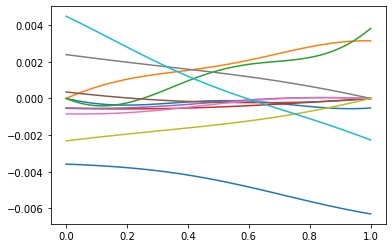

In [ ]:
plt.plot(inputs, numpy.swapaxes(x,0, 1))
plt.show()

In [ ]:
for i in range(11):
  print(i, ":", np.abs(x[i,:]).max())

0 : 0.00055897236
1 : 0.0031475425
2 : 0.003822267
3 : 0.00057032704
4 : 0.0005413601
5 : 0.0003530085
6 : 0.0008482672
7 : 0.002394788
8 : 0.002315756
9 : 0.0044888556
10 : 0.00630635


In [ ]:
np.abs(x).max()

DeviceArray(0.00630635, dtype=float32)

In [ ]:
res = numpy.empty((11, inputs.shape[0]))
j = 0
for t in inputs:
  out1 = nn_V(w1, t, consts)
  for i in range(11) :
    res[i, j] = out1[i]
 
  j+=1


In [ ]:
res0 = numpy.swapaxes(res,0, 1)

In [ ]:
res0[-1, 1]

0.9901816844940186

Text(0.5, 0, 't')

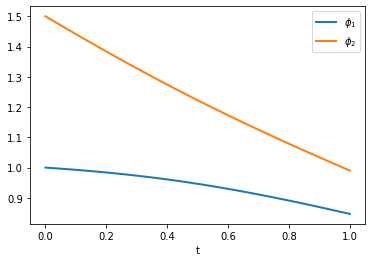

In [ ]:
plt.plot(inputs, res0[:, 0], linewidth=2)
plt.plot(inputs, res0[:, 1], linewidth=2)
#plt.plot(sol.t, s[:, 1], linewidth=2)
plt.legend(['$\phi_1$', '$\phi_2$'])
plt.gca().set_xlabel('t')
#plt.gca().set_ylabel(r'$\rho$')

Text(0, 0.5, '$\\rho$')

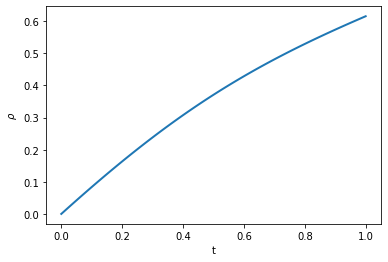

In [ ]:
plt.plot(inputs, res0[:, 2], linewidth=2)
#plt.plot(inputs, res0[:, 1], linewidth=2)
#plt.plot(sol.t, s[:, 1], linewidth=2)
#plt.legend(['$\phi_1$', '$\phi_2$'])
plt.gca().set_xlabel('t')
plt.gca().set_ylabel(r'$\rho$')

Text(0, 0.5, '$\\lambda_{ij}$')

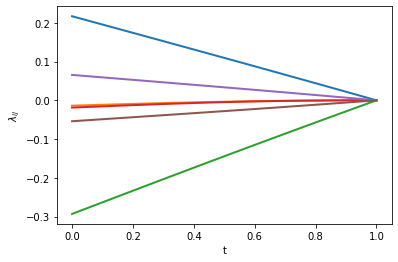

In [ ]:
plt.plot(inputs, res0[:, 3:9], linewidth=2)
#plt.plot(inputs, res0[:, 1], linewidth=2)
#plt.plot(sol.t, s[:, 1], linewidth=2)
#plt.legend(['$\phi_1$', '$\phi_2$'])
plt.gca().set_xlabel('t')
plt.gca().set_ylabel(r'$\lambda_{ij}$')

Text(0.5, 0, 't')

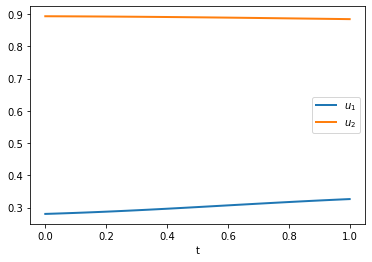

In [ ]:
plt.plot(inputs, res0[:, 9:11], linewidth=2)
#plt.plot(inputs, res0[:, 1], linewidth=2)
#plt.plot(sol.t, s[:, 1], linewidth=2)
plt.legend(['$u_1$', '$u_2$'])
plt.gca().set_xlabel('t')
#plt.gca().set_ylabel(r'$\lambda_{ij}$')

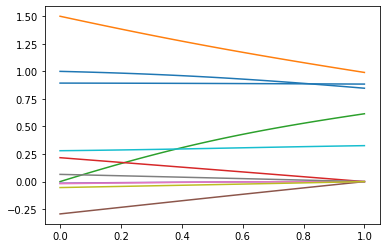

In [ ]:
plt.plot(inputs, numpy.swapaxes(res,0, 1))
plt.show()

**SHOOTING**

In [ ]:
def fun(t, y, c):
    phi = y[0]
    rho = y[1]
    L1 = y[2]
    L2 = y[3]

    H0 = L2*(-c['k']*rho + c['N']*phi*(1.-0.)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - rho/c['rhoMax'] * phi*(1.-0.)*c['v'])
    H1 = L2*(-c['k']*rho + c['N']*phi*(1.-0.9)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*0.9*0.9 - rho/c['rhoMax'] * phi*(1.-0.9)*c['v'])

    utest = np.clip(0.5*(-L2*c['N']*c['rhoMax'] + rho*c['v'] - c['n']*rho*c['v'] + c['n']*L1*rho*c['v'])/(c['rhoMax']*(1. - c['n']+ c['n']*L1)),0., 0.9)
    Hu = L2*(-c['k']*rho + c['N']*phi*(1-utest)) - c['b']*phi*L1 + (1. - c['n'] + c['n']*L1)*(c['z']*phi - phi*utest*utest - rho/c['rhoMax'] * phi*(1.-utest)*c['v'])

    if (H0 > H1 and H0 > Hu):
      u = 0.0
    elif (H1 > H0 and H1 > Hu):
      u = 0.9
    else:
      u = utest

    dphi = (-c['b']*phi + c['n']*(c['z']*phi - phi*u*u - rho/c['rhoMax'] * phi*(1.-u)*c['v']))
    drho = (-c['k']*rho + c['N']*phi*(1.-u))

    dL1 = -(L2*c['N']*(1.-u) - c['b']*L1 + 
                   (1.-c['n']+c['n']*L1)*(c['z'] - u*u - rho/c['rhoMax'] * (1.-u)*c['v']))
    dL2 = -(-L2*c['k'] - 
                   ((1.-c['n']+c['n']*L1)*phi*(1.-u)*c['v'])/c['rhoMax'])
    
    return numpy.array([dphi, drho, dL1, dL2])

In [ ]:
from scipy.integrate import solve_ivp

In [ ]:
sol = solve_ivp(fun, (consts['t0'], consts['t1']), [1. ,0., -0.49307835, -0.15152481], method='RK45', args=(consts,))

In [ ]:
sol.status

In [ ]:
sol.y

In [ ]:
sol.y[2:, -1]

In [ ]:
def shootin_func(x, c):
    sol = solve_ivp(fun, (c['t0'], c['t1']), [c['ics'][0] ,c['ics'][1], x[0], x[1]], method='DOP853', args=(c,),atol =1e-8, rtol=1e-8)#DOP853
    if sol.status == -1:
      raise NotImplementedError
      
    return sol.y[2:, -1]


In [ ]:
from scipy import optimize

In [ ]:
optimize.root(shootin_func, [1.0, 1.0],method='hybr', args=(consts,),tol=1e-8)

In [ ]:
sol = solve_ivp(fun, (consts['t0'], consts['t1']), [1. ,0., 0.00769373, -0.0021513], method='DOP853', args=(consts,), t_eval=inputs,atol =1e-8, rtol=1e-8)

In [ ]:
sol.y[:, 0]

In [ ]:
plt.plot(sol.t, numpy.swapaxes(sol.y, 1, 0))

In [ ]:
u=[]
M0 = consts['M0']
M1 = consts['M1']
M2 = consts['M2']
for x in inputs:
  u.append(nn_V(w1, x, consts) )

In [ ]:
u = np.array(u)
s = numpy.swapaxes(sol.y, 1, 0)

In [ ]:
plt.plot(inputs, u[:, 0], linewidth=4)
#plt.plot(sol.t, s[:, 0], linewidth=2)
plt.legend(['предложенный метод'])
plt.gca().set_xlabel('t')
plt.gca().set_ylabel('x')

In [ ]:
plt.plot(inputs, u[:, 1], linewidth=4)
#plt.plot(sol.t, s[:, 1], linewidth=2)
plt.legend(['предложенный метод', 'метод стрельбы'])
plt.gca().set_xlabel('t')
plt.gca().set_ylabel(r'$\rho$')

In [ ]:
plt.plot(inputs, u[:, 2], linewidth=4)
#plt.plot(sol.t, s[:, 2], linewidth=2)
plt.legend(['предложенный метод', 'метод стрельбы'])
plt.gca().set_xlabel('t')
plt.gca().set_ylabel(r'$\lambda_1$')

In [ ]:
plt.plot(inputs, u[:, 3], linewidth=4)
#plt.plot(sol.t, s[:, 3], linewidth=2)
plt.legend(['предложенный метод', 'метод стрельбы'])
plt.gca().set_xlabel('t')
plt.gca().set_ylabel(r'$\lambda_2$')

In [ ]:
s = []
for t, y in zip(sol.t, sol.y.swapaxes(1, 0)):
  s.append(nn_V(w1, t, consts) - y)

In [ ]:
s = numpy.abs(numpy.array(s))

In [ ]:
s[:, 0].max()

In [ ]:
s[:, 1].max()

In [ ]:
s[:, 2].max()

In [ ]:
s[:, 3].max()

In [ ]:
from scipy.integrate import quad
def integr_func(t, args):
  nn_in = v_nn_V(args['w'], np.array([t]), args['consts'])
  return F(nn_in, args['consts'])[args['id']]

print(quad(integr_func, a=consts['t0'], b=consts['t1'], args={'w':w1, 'consts':consts, 'id':0}))
print(quad(integr_func, a=consts['t0'], b=consts['t1'], args={'w':w1, 'consts':consts, 'id':1}))

(0.31601710490800083, 4.443372875793756e-09)
(0.10533010273916359, 1.4726922112708611e-08)


(0.10533010273916359,
 1.4726922112708611e-08,
 {'alist': array([1.87500000e-001, 5.00000000e-001, 2.50000000e-001, 0.00000000e+000,
         1.25000000e-001, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 1.39067116e-309, 1.39069238e-309, 1.39069238e-309,
         1.39069238e-309, 7.29290211e-304, 7.29290211e-304, 7.29290211e-304,
         7.29290211e-304, 7.29290211e-304, 7.29290211e-304, 7.29290211e-304,
         7.29290211e-304, 7.29290211e-304, 7.29290211e-304, 7.29290211e-304,
         7.29290211e-304, 7.29290211e-304, 7.29290211e-304, 7.29290211e-304,
         7.29290211e-304, 7.29290211e-304, 7.29290211e-304, 7.29290211e-304,
         7.29290211e-304, 7.29290211e-304, 7.74859723e-304, 7.74860419e-304,
         7.74860419e

In [ ]:
v_nn_V(w1, np.array([0.0]), consts)

DeviceArray([[ 1.        ,  1.5       ,  0.        ,  0.21697058,
              -0.01373078, -0.29313707, -0.01872876,  0.06554644,
              -0.05397238,  0.2801358 ,  0.8935338 ]], dtype=float32)